In [1]:
import sys
sys.path.append('..')
sys.path.append('../src')
sys.path.append('../data')

import torch
import plotly.express as px
import src.nanda_plot
from src.model import WrapHookedTransformer
from src.nanda_plot import imshow_reversed, imshow
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

In [2]:
import torch as th
from tuned_lens.plotting import PredictionTrajectory
from tuned_lens.nn import TunedLens, Unembed, LogitLens
import transformer_lens as tl
from src.model import WrapHookedTransformer

model = WrapHookedTransformer.from_pretrained(
    "gpt2",
    device="cpu",
    fold_ln=False, # The tuned lens applies the final layer norm so we should not fold
    # this into the unembed operation.
)
assert model.tokenizer is not None


tuned_lens = TunedLens.from_unembed_and_pretrained(
    unembed=Unembed(model),
    lens_resource_id="gpt2",
)

logit_lens = LogitLens.from_model(model)

def to_targets(input_ids: th.Tensor):
    return th.cat(
        (input_ids[..., 1:], th.full(input_ids.shape[:-1] + (1,), model.tokenizer.eos_token_id)
    ), dim=-1)

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2 into HookedTransformer


In [12]:
from src.dataset import Dataset
dataset = Dataset("../data/dataset_gpt2_f.json")
dataset.select_lenght(50,16)
dataset.select_dataset("mem")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=True)
batch = next(iter(dataloader))
input_ids_mem = model.to_tokens(batch["premise"])
targets_mem = model.to_tokens(batch["target"], prepend_bos=False)
anti_targets_mem = model.to_tokens(batch["orthogonal_token"], prepend_bos=False)
with th.inference_mode():
    logits, cache = model.run_with_cache(
        input=input_ids_mem, return_type="logits"
    )

    pred_traj_clean_mem = PredictionTrajectory.from_lens_and_cache(
        lens=tuned_lens,
        cache=cache,
        model_logits=logits,
        input_ids=input_ids_mem,
        residual_component="resid_mid",
        # targets=targets,
        # anti_targets=anti_targets,
    )
    
dataset = Dataset("../data/dataset_gpt2_f.json")
dataset.select_lenght(50,16)
dataset.select_dataset("cp")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=True)
batch = next(iter(dataloader))
input_ids_pos = model.to_tokens(batch["premise"])
targets_cp = model.to_tokens(batch["target"], prepend_bos=False)
anti_targets_cp = model.to_tokens(batch["orthogonal_token"], prepend_bos=False)
with th.inference_mode():
    logits, cache = model.run_with_cache(
        input=input_ids_pos, return_type="logits"
    )

    pred_traj_clean_cp = PredictionTrajectory.from_lens_and_cache(
        lens=tuned_lens,
        cache=cache,
        model_logits=logits,
        input_ids=input_ids_pos,
        residual_component="resid_mid",
        # targets=targets,
        # anti_targets=anti_targets,
    )



mem_dataset lenght: 50
cp_dataset lenght: 50
mem_dataset lenght: 50
cp_dataset lenght: 50


In [15]:
def centered_logit(logit, center=True):
    if center is False:
        
        print("Not centering")
        return logit
    mean = logit.mean(-1)
    return logit - np.expand_dims(mean, -1)

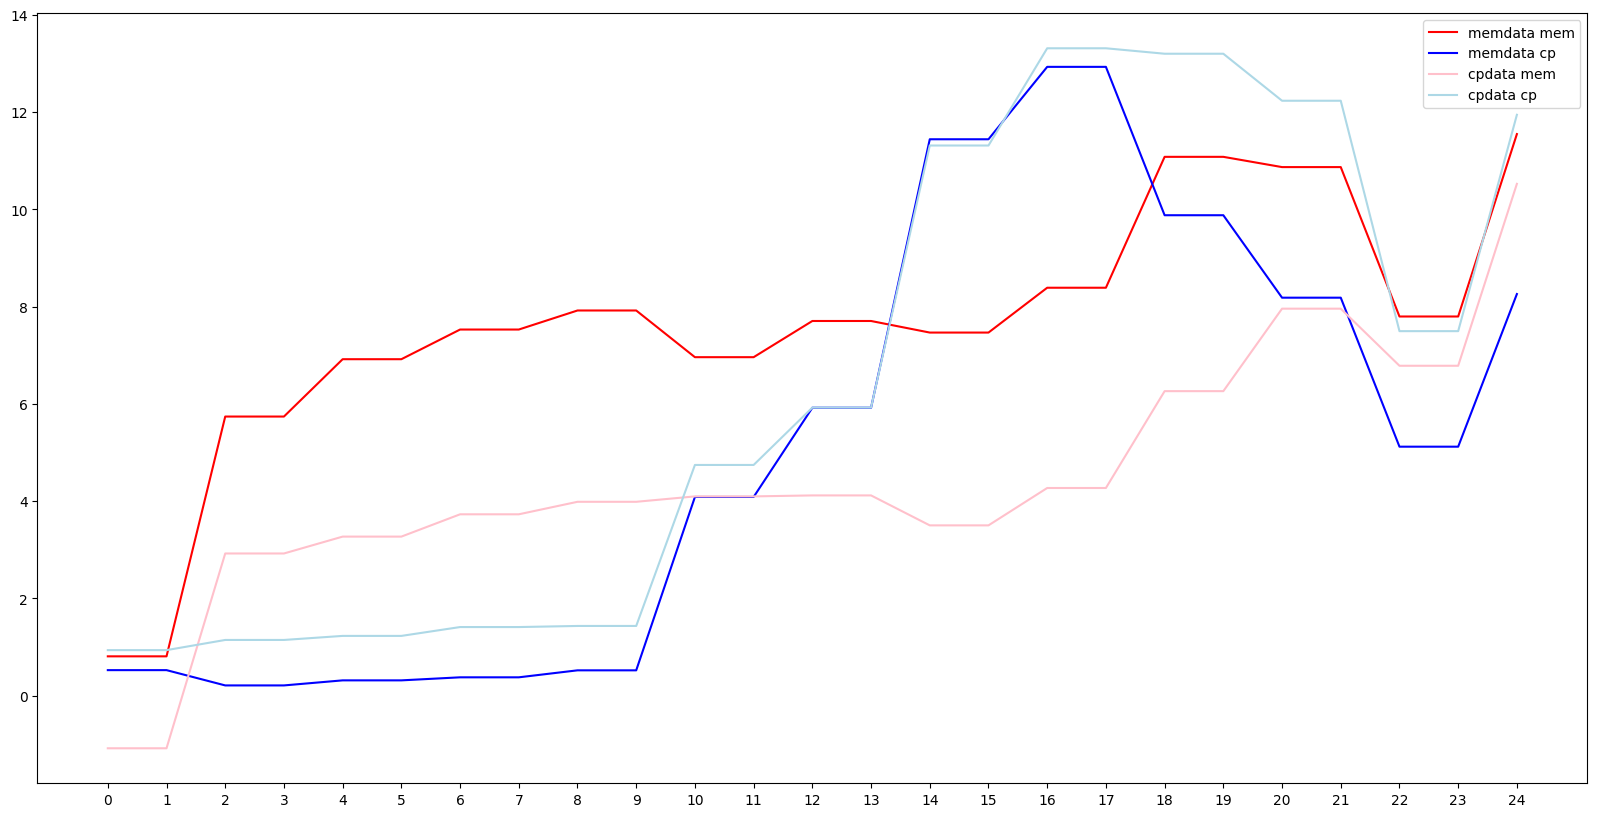

In [19]:
POS = -1

logit_mem = centered_logit(pred_traj_clean_mem.log_probs[:,:,POS,:])

logit_target_mem =  torch.gather(torch.tensor(logit_mem), 2, targets_mem.unsqueeze(1).expand(-1, 25, -1)).squeeze(-1).detach().numpy()
logit_anti_target_mem = torch.gather(torch.tensor(logit_mem), 2, anti_targets_mem.unsqueeze(1).expand(-1, 25, -1)).squeeze(-1).detach().numpy()


logit_cp = centered_logit(pred_traj_clean_cp.log_probs[:,:,POS,:])
logit_target_cp =  torch.gather(torch.tensor(logit_cp), 2, targets_cp.unsqueeze(1).expand(-1, 25, -1)).squeeze(-1).detach().numpy()
logit_anti_target_cp = torch.gather(torch.tensor(logit_cp), 2, anti_targets_cp.unsqueeze(1).expand(-1, 25, -1)).squeeze(-1).detach().numpy()

#plot 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#plot line plot
plt.figure(figsize=(20,10))
plt.plot(logit_target_mem.mean(0), label="memdata mem", color="red")
# add variance
# plt.fill_between(np.arange(13), logit_target.mean(0) - logit_target.std(0), logit_target.mean(0) + logit_target.std(0), alpha=0.3)
plt.plot(logit_anti_target_mem.mean(0), label="memdata cp", color="blue")
plt.plot(logit_target_cp.mean(0), label="cpdata mem", color="pink")
plt.plot(logit_anti_target_cp.mean(0), label="cpdata cp", color="lightblue")
# plt.fill_between(np.arange(13), logit_anti_target.mean(0) - logit_anti_target.std(0), logit_anti_target.mean(0) + logit_anti_target.std(0), alpha=0.3)
plt.xticks(np.arange(25))
plt.legend()

mem_dataset lenght: 50
cp_dataset lenght: 50
mem_dataset lenght: 50
cp_dataset lenght: 50


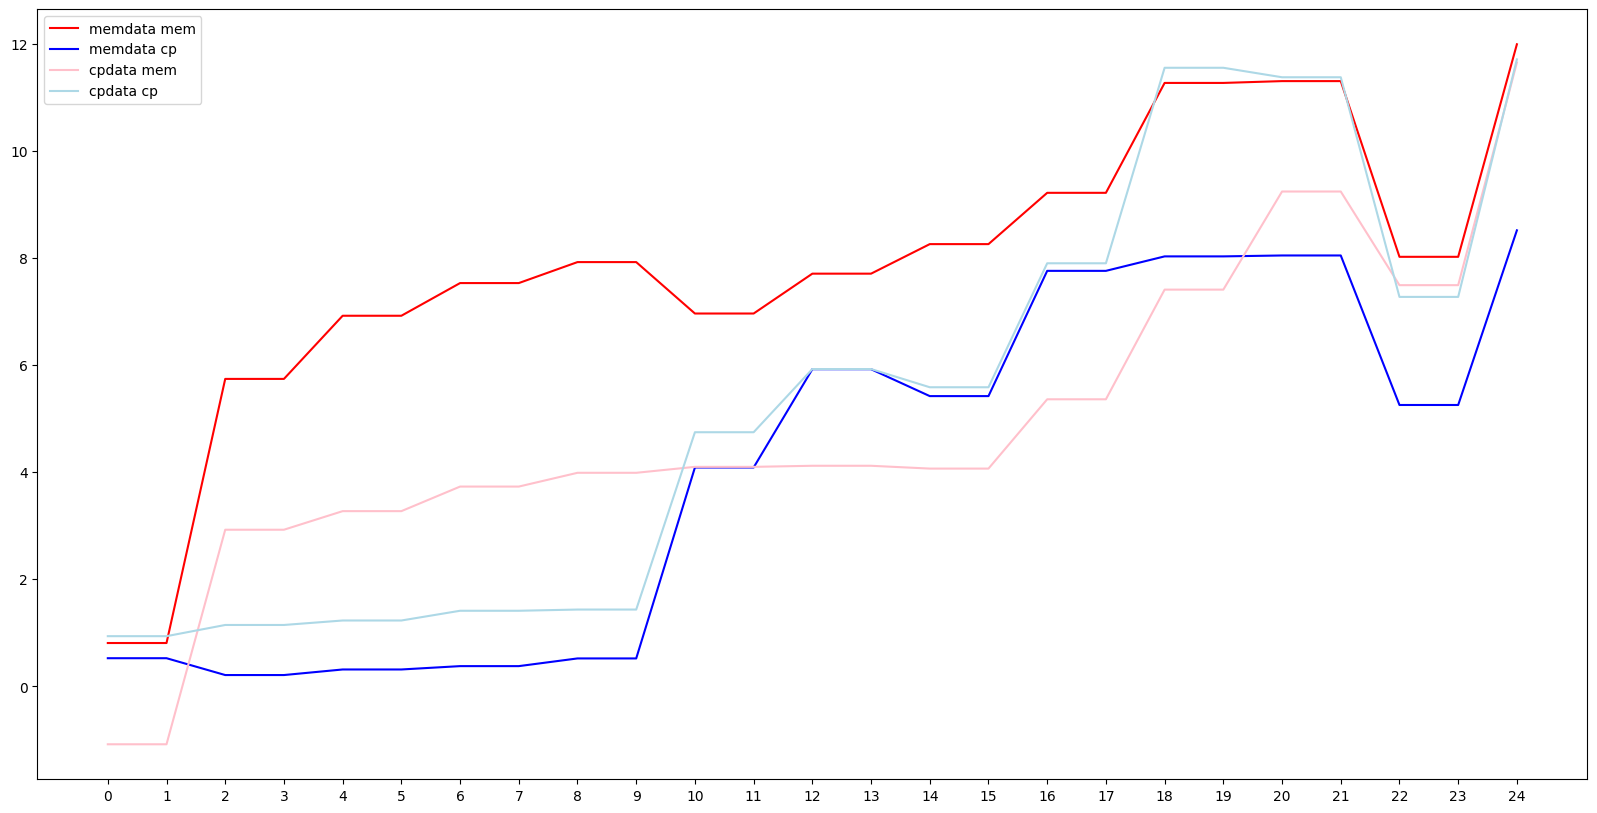

In [20]:
from src.dataset import Dataset
LAYER = 7
def ablation_hook(activation, hook):

    activation[:,-1,:] = 0
    return activation
dataset = Dataset("../data/dataset_gpt2_f.json")
dataset.select_lenght(50,16)
dataset.select_dataset("mem")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=True)
batch = next(iter(dataloader))
input_ids_mem = model.to_tokens(batch["premise"])
targets_mem = model.to_tokens(batch["target"], prepend_bos=False)
anti_targets_mem = model.to_tokens(batch["orthogonal_token"], prepend_bos=False)
with th.inference_mode():
    logit, cache = model.run_with_cache(
        input_ids_mem,
        fwd_hooks=[(f"blocks.{LAYER}.hook_attn_out", ablation_hook),
                #    (f"blocks.{LAYER+2}.hook_attn_out", ablation_hook)
        ]
    )

    pred_traj_clean_mem = PredictionTrajectory.from_lens_and_cache(
        lens=tuned_lens,
        cache=cache,
        model_logits=logit,
        input_ids=input_ids_mem,
        residual_component="resid_mid",
        # targets=targets,
        # anti_targets=anti_targets,
    )
    
dataset = Dataset("../data/dataset_gpt2_f.json")
dataset.select_lenght(50,16)
dataset.select_dataset("cp")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=True)
batch = next(iter(dataloader))
input_ids_pos = model.to_tokens(batch["premise"])
targets_cp = model.to_tokens(batch["target"], prepend_bos=False)
anti_targets_cp = model.to_tokens(batch["orthogonal_token"], prepend_bos=False)
with th.inference_mode():

    logit, cache = model.run_with_cache(
        input_ids_pos,
        fwd_hooks=[(f"blocks.{LAYER}.hook_attn_out", ablation_hook),
                #    (f"blocks.{LAYER+2}.hook_attn_out", ablation_hook)
        ]
    )

    pred_traj_clean_cp = PredictionTrajectory.from_lens_and_cache(
        lens=tuned_lens,
        cache=cache,
        model_logits=logit,
        input_ids=input_ids_pos,
        residual_component="resid_mid",
        # targets=targets,
        # anti_targets=anti_targets,
    )

POS = -1

logit_mem = centered_logit(pred_traj_clean_mem.log_probs[:,:,POS,:])
logit_target_mem =  torch.gather(torch.tensor(logit_mem), 2, targets_mem.unsqueeze(1).expand(-1, 25, -1)).squeeze(-1).detach().numpy()
logit_anti_target_mem = torch.gather(torch.tensor(logit_mem), 2, anti_targets_mem.unsqueeze(1).expand(-1, 25, -1)).squeeze(-1).detach().numpy()


logit_cp = centered_logit(pred_traj_clean_cp.log_probs[:,:,POS,:])
logit_target_cp =  torch.gather(torch.tensor(logit_cp), 2, targets_cp.unsqueeze(1).expand(-1, 25, -1)).squeeze(-1).detach().numpy()
logit_anti_target_cp = torch.gather(torch.tensor(logit_cp), 2, anti_targets_cp.unsqueeze(1).expand(-1, 25, -1)).squeeze(-1).detach().numpy()

#plot 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#plot line plot
plt.figure(figsize=(20,10))
plt.plot(logit_target_mem.mean(0), label="memdata mem", color="red")
# add variance
# plt.fill_between(np.arange(13), logit_target.mean(0) - logit_target.std(0), logit_target.mean(0) + logit_target.std(0), alpha=0.3)
plt.plot(logit_anti_target_mem.mean(0), label="memdata cp", color="blue")
plt.plot(logit_target_cp.mean(0), label="cpdata mem", color="pink")
plt.plot(logit_anti_target_cp.mean(0), label="cpdata cp", color="lightblue")
# plt.fill_between(np.arange(13), logit_anti_target.mean(0) - logit_anti_target.std(0), logit_anti_target.mean(0) + logit_anti_target.std(0), alpha=0.3)
plt.xticks(np.arange(25))
plt.legend()


mem_dataset lenght: 50
cp_dataset lenght: 50
mem_dataset lenght: 50
cp_dataset lenght: 50


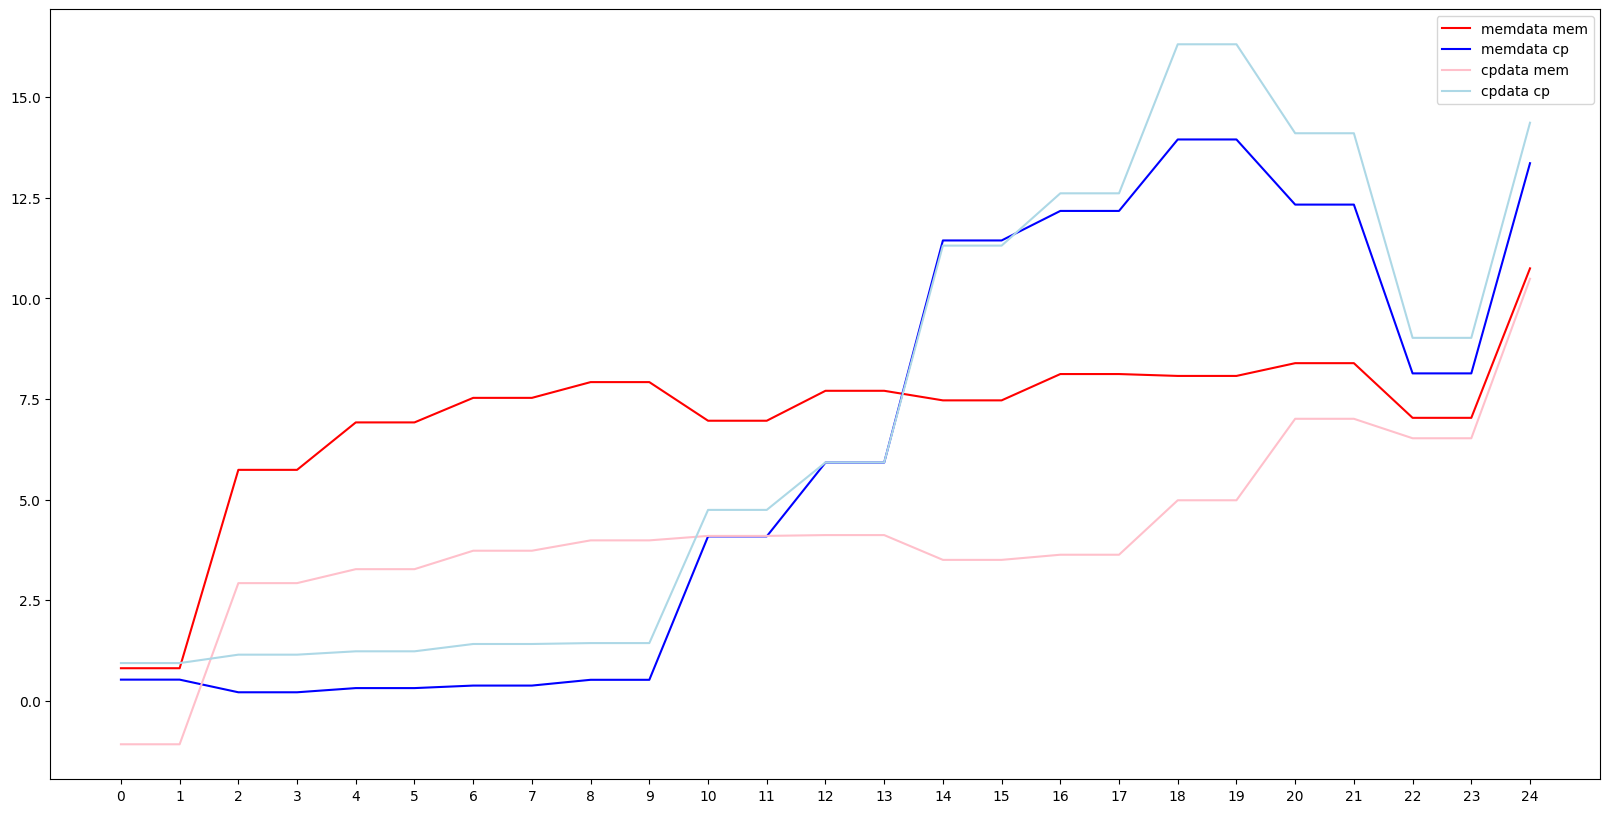

In [21]:
from src.dataset import Dataset
LAYER = 8
def ablation_hook(activation, hook):

    activation[:,-1,:] = 0
    return activation
dataset = Dataset("../data/dataset_gpt2_f.json")
dataset.select_lenght(50,16)
dataset.select_dataset("mem")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=True)
batch = next(iter(dataloader))
input_ids_mem = model.to_tokens(batch["premise"])
targets_mem = model.to_tokens(batch["target"], prepend_bos=False)
anti_targets_mem = model.to_tokens(batch["orthogonal_token"], prepend_bos=False)
with th.inference_mode():
    logit, cache = model.run_with_cache(
        input_ids_mem,
        fwd_hooks=[(f"blocks.{LAYER}.hook_attn_out", ablation_hook),
                #    (f"blocks.{LAYER+2}.hook_attn_out", ablation_hook)
        ]
    )

    pred_traj_clean_mem = PredictionTrajectory.from_lens_and_cache(
        lens=tuned_lens,
        cache=cache,
        model_logits=logit,
        input_ids=input_ids_mem,
        residual_component="resid_mid",
        # targets=targets,
        # anti_targets=anti_targets,
    )
    
dataset = Dataset("../data/dataset_gpt2_f.json")
dataset.select_lenght(50,16)
dataset.select_dataset("cp")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=True)
batch = next(iter(dataloader))
input_ids_pos = model.to_tokens(batch["premise"])
targets_cp = model.to_tokens(batch["target"], prepend_bos=False)
anti_targets_cp = model.to_tokens(batch["orthogonal_token"], prepend_bos=False)
with th.inference_mode():

    logit, cache = model.run_with_cache(
        input_ids_pos,
        fwd_hooks=[(f"blocks.{LAYER}.hook_attn_out", ablation_hook),
                #    (f"blocks.{LAYER+2}.hook_attn_out", ablation_hook)
        ]
    )

    pred_traj_clean_cp = PredictionTrajectory.from_lens_and_cache(
        lens=tuned_lens,
        cache=cache,
        model_logits=logit,
        input_ids=input_ids_pos,
        residual_component="resid_mid",
        # targets=targets,
        # anti_targets=anti_targets,
    )

POS = -1

logit_mem = centered_logit(pred_traj_clean_mem.log_probs[:,:,POS,:])
logit_target_mem =  torch.gather(torch.tensor(logit_mem), 2, targets_mem.unsqueeze(1).expand(-1, 25, -1)).squeeze(-1).detach().numpy()
logit_anti_target_mem = torch.gather(torch.tensor(logit_mem), 2, anti_targets_mem.unsqueeze(1).expand(-1, 25, -1)).squeeze(-1).detach().numpy()


logit_cp = centered_logit(pred_traj_clean_cp.log_probs[:,:,POS,:])
logit_target_cp =  torch.gather(torch.tensor(logit_cp), 2, targets_cp.unsqueeze(1).expand(-1, 25, -1)).squeeze(-1).detach().numpy()
logit_anti_target_cp = torch.gather(torch.tensor(logit_cp), 2, anti_targets_cp.unsqueeze(1).expand(-1, 25, -1)).squeeze(-1).detach().numpy()

#plot 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#plot line plot
plt.figure(figsize=(20,10))
plt.plot(logit_target_mem.mean(0), label="memdata mem", color="red")
# add variance
# plt.fill_between(np.arange(13), logit_target.mean(0) - logit_target.std(0), logit_target.mean(0) + logit_target.std(0), alpha=0.3)
plt.plot(logit_anti_target_mem.mean(0), label="memdata cp", color="blue")
plt.plot(logit_target_cp.mean(0), label="cpdata mem", color="pink")
plt.plot(logit_anti_target_cp.mean(0), label="cpdata cp", color="lightblue")
# plt.fill_between(np.arange(13), logit_anti_target.mean(0) - logit_anti_target.std(0), logit_anti_target.mean(0) + logit_anti_target.std(0), alpha=0.3)
plt.xticks(np.arange(25))
plt.legend()


mem_dataset lenght: 50
cp_dataset lenght: 50
mem_dataset lenght: 50
cp_dataset lenght: 50


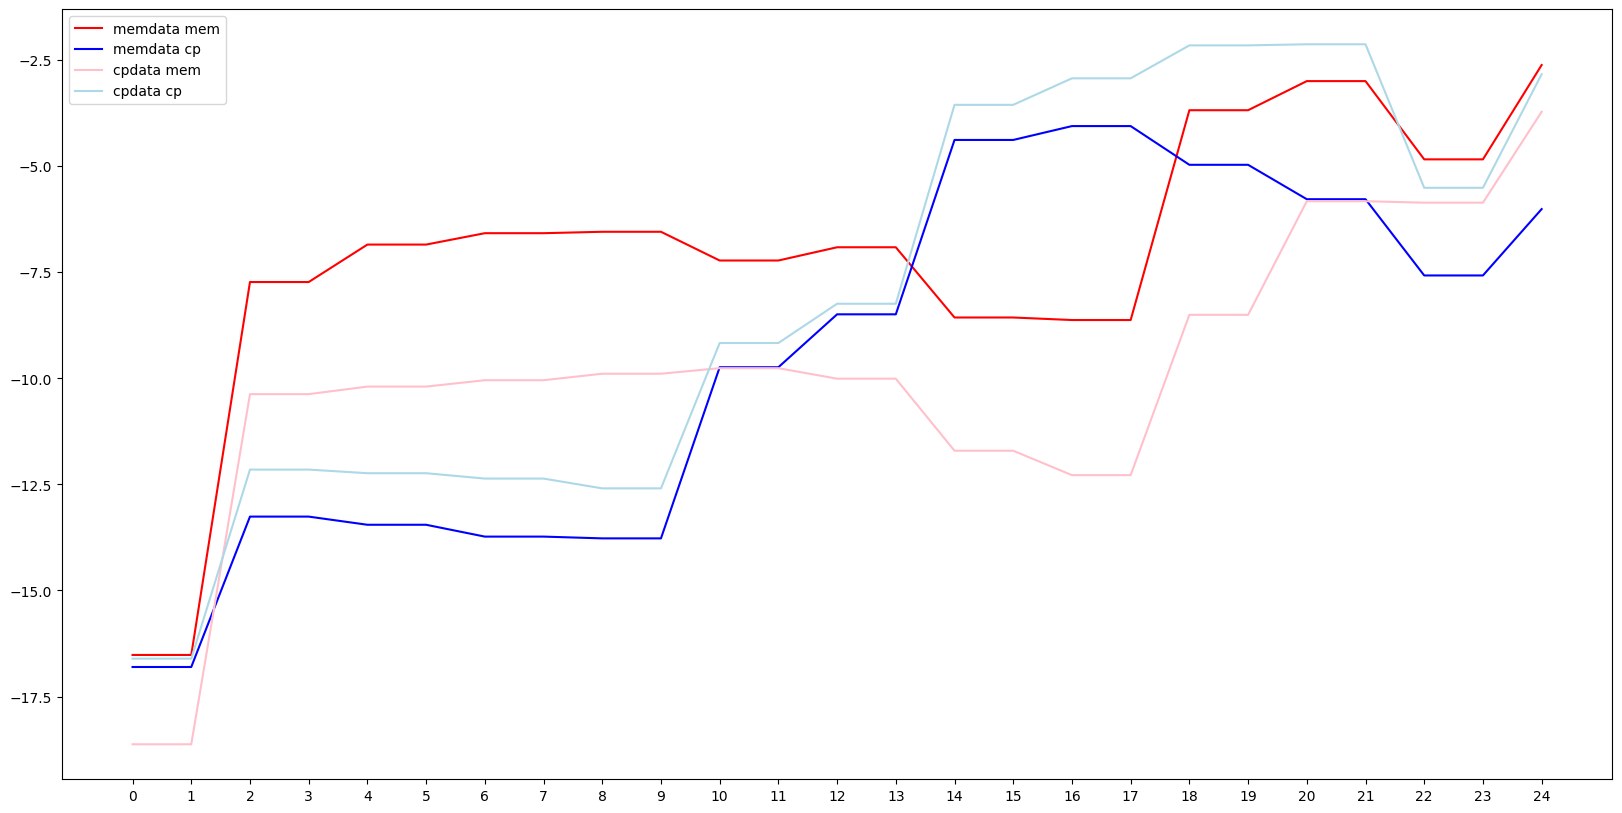

In [20]:
from src.dataset import Dataset
LAYER = 4
def ablation_hook(activation, hook):

    activation[:,-1,:] = 0
    return activation
dataset = Dataset("../data/dataset_gpt2_f.json")
dataset.select_lenght(50,16)
dataset.select_dataset("mem")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=True)
batch = next(iter(dataloader))
input_ids_mem = model.to_tokens(batch["premise"])
targets_mem = model.to_tokens(batch["target"], prepend_bos=False)
anti_targets_mem = model.to_tokens(batch["orthogonal_token"], prepend_bos=False)
with th.inference_mode():
    logit, cache = model.run_with_cache(
        input_ids_mem,
        fwd_hooks=[(f"blocks.{LAYER}.hook_attn_out", ablation_hook),
                #    (f"blocks.{LAYER+2}.hook_attn_out", ablation_hook)
        ]
    )

    pred_traj_clean_mem = PredictionTrajectory.from_lens_and_cache(
        lens=tuned_lens,
        cache=cache,
        model_logits=logit,
        input_ids=input_ids_mem,
        residual_component="resid_mid",
        # targets=targets,
        # anti_targets=anti_targets,
    )
    
dataset = Dataset("../data/dataset_gpt2_f.json")
dataset.select_lenght(50,16)
dataset.select_dataset("cp")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=True)
batch = next(iter(dataloader))
input_ids_pos = model.to_tokens(batch["premise"])
targets_cp = model.to_tokens(batch["target"], prepend_bos=False)
anti_targets_cp = model.to_tokens(batch["orthogonal_token"], prepend_bos=False)
with th.inference_mode():

    logit, cache = model.run_with_cache(
        input_ids_pos,
        fwd_hooks=[(f"blocks.{LAYER}.hook_attn_out", ablation_hook),
                #    (f"blocks.{LAYER+2}.hook_attn_out", ablation_hook)
        ]
    )

    pred_traj_clean_cp = PredictionTrajectory.from_lens_and_cache(
        lens=tuned_lens,
        cache=cache,
        model_logits=logit,
        input_ids=input_ids_pos,
        residual_component="resid_mid",
        # targets=targets,
        # anti_targets=anti_targets,
    )

POS = -1

logit_mem = pred_traj_clean_mem.log_probs[:,:,POS,:]
logit_target_mem =  torch.gather(torch.tensor(logit_mem), 2, targets_mem.unsqueeze(1).expand(-1, 25, -1)).squeeze(-1).detach().numpy()
logit_anti_target_mem = torch.gather(torch.tensor(logit_mem), 2, anti_targets_mem.unsqueeze(1).expand(-1, 25, -1)).squeeze(-1).detach().numpy()


logit_cp = pred_traj_clean_cp.log_probs[:,:,POS,:]
logit_target_cp =  torch.gather(torch.tensor(logit_cp), 2, targets_cp.unsqueeze(1).expand(-1, 25, -1)).squeeze(-1).detach().numpy()
logit_anti_target_cp = torch.gather(torch.tensor(logit_cp), 2, anti_targets_cp.unsqueeze(1).expand(-1, 25, -1)).squeeze(-1).detach().numpy()

#plot 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#plot line plot
plt.figure(figsize=(20,10))
plt.plot(logit_target_mem.mean(0), label="memdata mem", color="red")
# add variance
# plt.fill_between(np.arange(13), logit_target.mean(0) - logit_target.std(0), logit_target.mean(0) + logit_target.std(0), alpha=0.3)
plt.plot(logit_anti_target_mem.mean(0), label="memdata cp", color="blue")
plt.plot(logit_target_cp.mean(0), label="cpdata mem", color="pink")
plt.plot(logit_anti_target_cp.mean(0), label="cpdata cp", color="lightblue")
# plt.fill_between(np.arange(13), logit_anti_target.mean(0) - logit_anti_target.std(0), logit_anti_target.mean(0) + logit_anti_target.std(0), alpha=0.3)
plt.xticks(np.arange(25))
plt.legend()


mem_dataset lenght: 50
cp_dataset lenght: 50
mem_dataset lenght: 50
cp_dataset lenght: 50
torch.Size([50, 25, 50257])


/tmp/ipykernel_259633/2675601096.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logit_target_mem =  torch.gather(torch.tensor(logit_mem), 2, targets_mem.unsqueeze(1).expand(-1, 25, -1)).squeeze(-1).detach().numpy()
/tmp/ipykernel_259633/2675601096.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logit_anti_target_mem = torch.gather(torch.tensor(logit_mem), 2, anti_targets_mem.unsqueeze(1).expand(-1, 25, -1)).squeeze(-1).detach().numpy()
/tmp/ipykernel_259633/2675601096.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logit_t

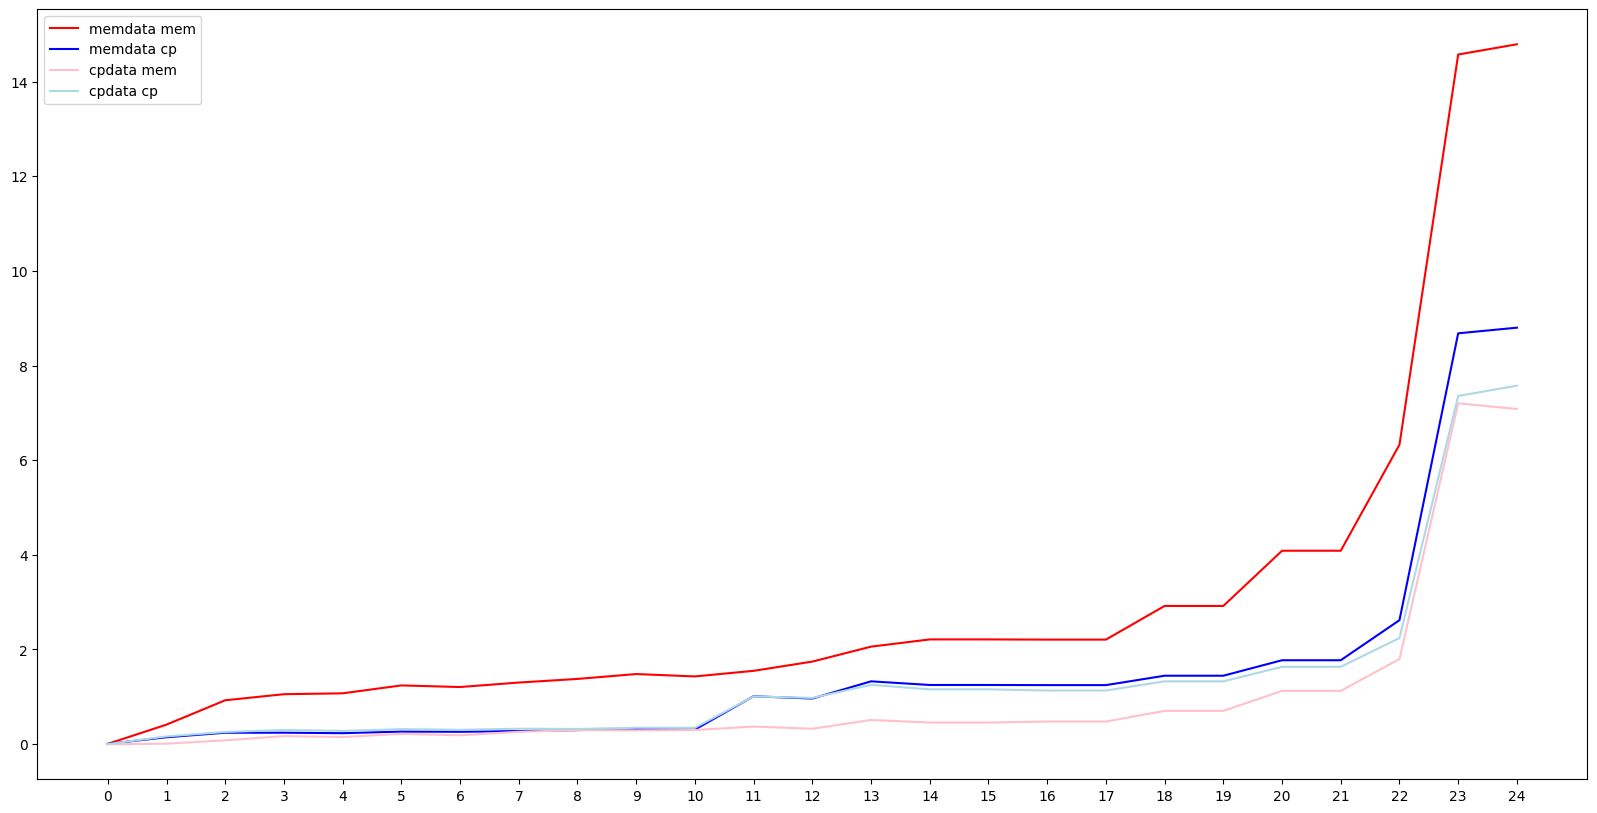

In [50]:
from src.dataset import Dataset
import einops
LAYER = 7
def ablation_hook(activation, hook):

    activation[:,-1,:] = 0
    return activation
dataset = Dataset("../data/dataset_gpt2_f.json")
dataset.select_lenght(50,16)
dataset.select_dataset("mem")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=True)
batch = next(iter(dataloader))
input_ids_mem = model.to_tokens(batch["premise"])
targets_mem = model.to_tokens(batch["target"], prepend_bos=False)
anti_targets_mem = model.to_tokens(batch["orthogonal_token"], prepend_bos=False)
with th.inference_mode():
    logit, cache = model.run_with_cache(
        input_ids_mem,
        fwd_hooks=[(f"blocks.{LAYER}.hook_attn_out", ablation_hook),
                   (f"blocks.{LAYER+1}.hook_attn_out", ablation_hook),
                   (f"blocks.{LAYER+2}.hook_attn_out", ablation_hook),
                   (f"blocks.{LAYER+3}.hook_attn_out", ablation_hook)
        ]
    )
    accumulated_residual, labels = cache.accumulated_resid(
        layer=-1, incl_mid=True, return_labels=True, pos_slice=-1
    )
    accumulated_residual = cache.apply_ln_to_stack(
        accumulated_residual, layer=-1,pos_slice=-1
    )
    mem_unembed_accumulated_residual = einops.einsum(
        accumulated_residual,
        model.W_U,
        "n b d, d v -> b n v",
    )
    
    
dataset = Dataset("../data/dataset_gpt2_f.json")
dataset.select_lenght(50,16)
dataset.select_dataset("cp")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=True)
batch = next(iter(dataloader))
input_ids_pos = model.to_tokens(batch["premise"])
targets_cp = model.to_tokens(batch["target"], prepend_bos=False)
anti_targets_cp = model.to_tokens(batch["orthogonal_token"], prepend_bos=False)
with th.inference_mode():

    logit, cache = model.run_with_cache(
        input_ids_pos,
        fwd_hooks=[(f"blocks.{LAYER}.hook_attn_out", ablation_hook),
                   (f"blocks.{LAYER+1}.hook_attn_out", ablation_hook),
                   (f"blocks.{LAYER+2}.hook_attn_out", ablation_hook),
                   (f"blocks.{LAYER+3}.hook_attn_out", ablation_hook)
        ]
    )

    accumulated_residual, labels = cache.accumulated_resid(
        layer=-1, incl_mid=True, return_labels=True, pos_slice=-1
    )
    accumulated_residual = cache.apply_ln_to_stack(
        accumulated_residual, layer=-1,pos_slice=-1
    )
    cp_unembed_accumulated_residual = einops.einsum(
        accumulated_residual,
        model.W_U,
        "n b d, d v -> b n v",
    )

print(cp_unembed_accumulated_residual.shape)

logit_mem = centered_logit(mem_unembed_accumulated_residual.clone().detach())
logit_target_mem =  torch.gather(torch.tensor(logit_mem), 2, targets_mem.unsqueeze(1).expand(-1, 25, -1)).squeeze(-1).detach().numpy()
logit_anti_target_mem = torch.gather(torch.tensor(logit_mem), 2, anti_targets_mem.unsqueeze(1).expand(-1, 25, -1)).squeeze(-1).detach().numpy()


logit_cp = centered_logit(cp_unembed_accumulated_residual)
logit_target_cp =  torch.gather(torch.tensor(logit_cp), 2, targets_cp.unsqueeze(1).expand(-1, 25, -1)).squeeze(-1).detach().numpy()
logit_anti_target_cp = torch.gather(torch.tensor(logit_cp), 2, anti_targets_cp.unsqueeze(1).expand(-1, 25, -1)).squeeze(-1).detach().numpy()

#plot 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#plot line plot
plt.figure(figsize=(20,10))
plt.plot(logit_target_mem.mean(0), label="memdata mem", color="red")
# add variance
# plt.fill_between(np.arange(13), logit_target.mean(0) - logit_target.std(0), logit_target.mean(0) + logit_target.std(0), alpha=0.3)
plt.plot(logit_anti_target_mem.mean(0), label="memdata cp", color="blue")
plt.plot(logit_target_cp.mean(0), label="cpdata mem", color="pink")
plt.plot(logit_anti_target_cp.mean(0), label="cpdata cp", color="lightblue")
# plt.fill_between(np.arange(13), logit_anti_target.mean(0) - logit_anti_target.std(0), logit_anti_target.mean(0) + logit_anti_target.std(0), alpha=0.3)
plt.xticks(np.arange(25))
plt.legend()


mem_dataset lenght: 50
cp_dataset lenght: 50
mem_dataset lenght: 50
cp_dataset lenght: 50


/tmp/ipykernel_303875/1705238851.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logit_target_mem =  torch.gather(torch.tensor(logit_mem), 2, targets_mem.unsqueeze(1).expand(-1, 25, -1)).squeeze(-1).detach().numpy()
/tmp/ipykernel_303875/1705238851.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logit_anti_target_mem = torch.gather(torch.tensor(logit_mem), 2, anti_targets_mem.unsqueeze(1).expand(-1, 25, -1)).squeeze(-1).detach().numpy()
/tmp/ipykernel_303875/1705238851.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logit_t

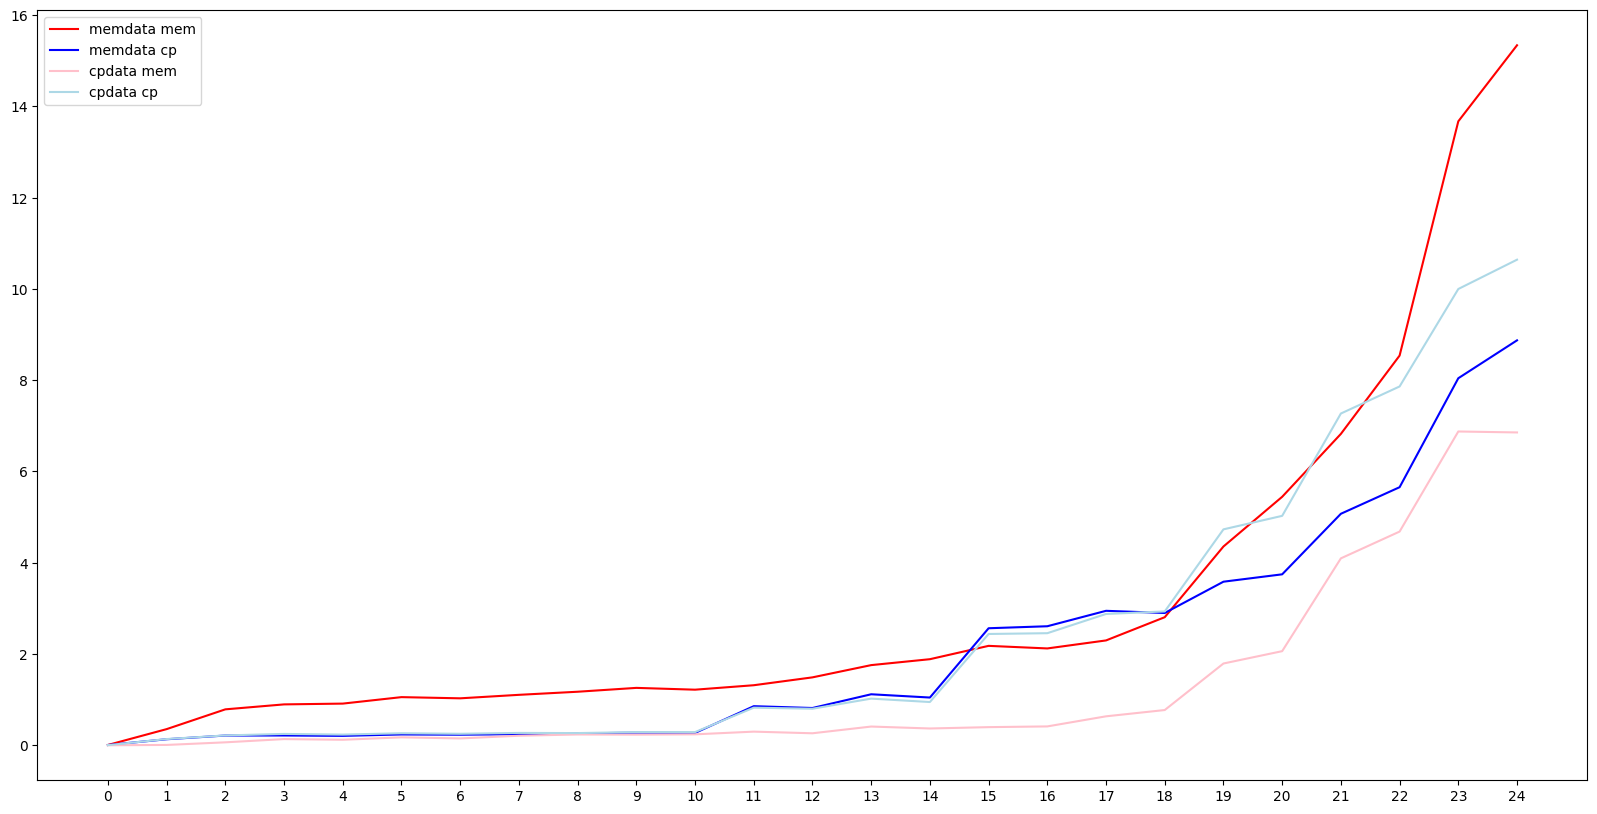

In [21]:
from src.dataset import Dataset
import einops
LAYER = 7
def ablation_hook(activation, hook):

    activation[:,-1,:] = 0
    return activation
dataset = Dataset("../data/dataset_gpt2_f.json")
dataset.select_lenght(50,16)
dataset.select_dataset("mem")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=True)
batch = next(iter(dataloader))
input_ids_mem = model.to_tokens(batch["premise"])
targets_mem = model.to_tokens(batch["target"], prepend_bos=False)
anti_targets_mem = model.to_tokens(batch["orthogonal_token"], prepend_bos=False)
with th.inference_mode():
    logit, cache = model.run_with_cache(
        input_ids_mem,
    )
    accumulated_residual, labels = cache.accumulated_resid(
        layer=-1, incl_mid=True, return_labels=True, pos_slice=-1
    )
    accumulated_residual = cache.apply_ln_to_stack(
        accumulated_residual, layer=-1,pos_slice=-1
    )
    mem_unembed_accumulated_residual = einops.einsum(
        accumulated_residual,
        model.W_U,
        "n b d, d v -> b n v",
    )
    
    
dataset = Dataset("../data/dataset_gpt2_f.json")
dataset.select_lenght(50,16)
dataset.select_dataset("cp")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=True)
batch = next(iter(dataloader))
input_ids_pos = model.to_tokens(batch["premise"])
targets_cp = model.to_tokens(batch["target"], prepend_bos=False)
anti_targets_cp = model.to_tokens(batch["orthogonal_token"], prepend_bos=False)
with th.inference_mode():

    logit, cache = model.run_with_cache(
        input_ids_pos,
    )

    accumulated_residual, labels = cache.accumulated_resid(
        layer=-1, incl_mid=True, return_labels=True, pos_slice=-1, apply_ln=True
    )
    # accumulated_residual = cache.apply_ln_to_stack(
    #     accumulated_residual, layer=-1,pos_slice=-1
    # )
    cp_unembed_accumulated_residual = einops.einsum(
        accumulated_residual,
        model.W_U,
        "n b d, d v -> b n v",
    )


# mem_unembed_accumulated_residual = torch.softmax(mem_unembed_accumulated_residual, dim=-1)
logit_mem = centered_logit(mem_unembed_accumulated_residual.clone().detach(), True)
logit_target_mem =  torch.gather(torch.tensor(logit_mem), 2, targets_mem.unsqueeze(1).expand(-1, 25, -1)).squeeze(-1).detach().numpy()
logit_anti_target_mem = torch.gather(torch.tensor(logit_mem), 2, anti_targets_mem.unsqueeze(1).expand(-1, 25, -1)).squeeze(-1).detach().numpy()

# cp_unembed_accumulated_residual = torch.softmax(cp_unembed_accumulated_residual, dim=-1)
logit_cp = centered_logit(cp_unembed_accumulated_residual, True)
logit_target_cp =  torch.gather(torch.tensor(logit_cp), 2, targets_cp.unsqueeze(1).expand(-1, 25, -1)).squeeze(-1).detach().numpy()
logit_anti_target_cp = torch.gather(torch.tensor(logit_cp), 2, anti_targets_cp.unsqueeze(1).expand(-1, 25, -1)).squeeze(-1).detach().numpy()

#plot 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#plot line plot
plt.figure(figsize=(20,10))
plt.plot(logit_target_mem.mean(0), label="memdata mem", color="red")
# add variance
# plt.fill_between(np.arange(13), logit_target.mean(0) - logit_target.std(0), logit_target.mean(0) + logit_target.std(0), alpha=0.3)
plt.plot(logit_anti_target_mem.mean(0), label="memdata cp", color="blue")
plt.plot(logit_target_cp.mean(0), label="cpdata mem", color="pink")
plt.plot(logit_anti_target_cp.mean(0), label="cpdata cp", color="lightblue")
# plt.fill_between(np.arange(13), logit_anti_target.mean(0) - logit_anti_target.std(0), logit_anti_target.mean(0) + logit_anti_target.std(0), alpha=0.3)
plt.xticks(np.arange(25))
plt.legend()
